In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.analysis import *
from src.theory import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

# Global parameters

In [2]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'sigma': 0.01, # std of additive Gaussian noise
    'epsilon': 0.1, # error threshold for overlap
}

# Load analytic solution for $T\to\infty$

In [3]:
filename_inf = f"results/results_analytic_inf_N{params['N']}_mu{params['mu']}_epsilon{params['epsilon']}_sigma{params['sigma']}.txt"
if os.path.isfile(filename_inf):
    lams_inf, drs_inf, nds_inf = np.loadtxt(filename_inf).T
    print(lams_inf)
else:
    raise ValueError("file not found")

[0.         0.13403568 0.25010579 0.35061837 0.43765867 0.51303247
 0.5783035  0.63482587 0.68377223 0.72615804 0.76286263 0.7946475
 0.82217206 0.84600735 0.86664786 0.8845218  0.9        0.91340357
 0.92501058 0.93506184 0.94376587 0.95130325 0.95783035 0.96348259
 0.96837722 0.9726158  0.97628626 0.97946475 0.98221721 0.98460073
 0.98666479 0.98845218 0.99       0.99134036 0.99250106 0.99350618
 0.99437659 0.99513032 0.99578303 0.99634826 0.99683772 0.99726158
 0.99762863 0.99794647 0.99822172 0.99846007 0.99866648 0.99884522
 0.999      0.99913404 0.99925011 0.99935062 0.99943766 0.99951303
 0.9995783  0.99963483 0.99968377 0.99972616 0.99976286 0.99979465
 0.99982217 0.99984601 0.99986665 0.99988452 0.9999    ]


# Load analytic solution for $T \to 0$ 

In [4]:
filename_0 = f"results/results_analytic_0_N{params['N']}_mu{params['mu']}_epsilon{params['epsilon']}_sigma{params['sigma']}.txt"

if os.path.isfile(filename_0):
    lams_0, drs_0, nds_0 = np.loadtxt(filename_0).T 
else: 
    raise ValueError("file not found")

# Load analysed data and process for plotting

In [5]:
import sqlite3
con = sqlite3.connect('simulations.db')
cur = con.cursor()
# load dataframe from table
results = pd.read_sql_query(f"SELECT * FROM results WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND sigma={params['sigma']} AND epsilon={params['epsilon']}", con)
results.drop(columns=['N', 'K', 'mu', 'sigma', 'epsilon'], inplace=True)
con.close()

results.seed.unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1008, 1009])

In [6]:
# check consistency for subsequent analysis: all seeds should have all windows!
for seed in results.seed.unique():
    for window in results.window.unique():
        if not len(results[(results.seed==seed) & (results.window==window)])==1:
            print(f"seed {seed} window {window} not found!")

In [7]:
# load data and calculate maxima of drs and nds
windows = np.sort(results["window"].unique())
focus_windows = [1e0,1e1,1e2,1e3,1e4]
focus_legends = ["$10^0$ ms", "$10^1$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]
seeds = np.sort(results.seed.unique())
# seeds = [1000,]
print(seeds)

focus_lam = [[] for i in range(len(focus_windows))]
focus_nds = [[] for i in range(len(focus_windows))]
focus_drs = [[] for i in range(len(focus_windows))]
lam_max_nds = [[] for i in range(len(windows))]
lam_max_drs = [[] for i in range(len(windows))]
# iterate over all windows
for (i,window) in enumerate(windows):
    # reduce dataframe to current window
    sel = results[results["window"] == window]
    for (s, seed) in enumerate(seeds):
        # load file
        filename = results[(results["window"] == window) & (results["seed"] == seed)].filename.values[0]
        # reduce filename to the path from ./results/
        filename = filename[filename.find("results/"):] 
        lams_data, drs_data, nds_data = np.loadtxt(f"{filename}", skiprows=1, unpack=True)
        # find lamda value of maximum from left and from right
        lam_max_nds[i].append([lams_data[np.argmax(nds_data)], lams_data[len(nds_data) - np.argmax(nds_data[::-1]) - 1]])
        lam_max_drs[i].append([lams_data[np.argmax(drs_data)], lams_data[len(drs_data) - np.argmax(drs_data[::-1]) - 1]])
        if not len(lams_data) > 60:
            print("problem with result {}_{}".format(window, seed))
        if window in focus_windows:
            focus_lam[focus_windows.index(window)].append(lams_data)
            focus_nds[focus_windows.index(window)].append(nds_data)
            focus_drs[focus_windows.index(window)].append(drs_data)

# for each window calculate the mean lower and upper lambda value
lam_max_nds = np.array(lam_max_nds)
lam_max_drs = np.array(lam_max_drs)
# for nds plot range
lam_max_nds_lower = np.mean(lam_max_nds[:, :, 0], axis=1)
lam_max_nds_upper = np.mean(lam_max_nds[:, :, 1], axis=1)

# for drs calculate mean and variance (after mean over bounds, axis=2)
lam_max_drs_mean = np.mean(np.mean(lam_max_drs, axis=2), axis=1)
lam_max_drs_std = np.std(np.mean(lam_max_drs, axis=2), axis=1)

[1000 1001 1002 1003 1004 1005 1006 1008 1009]


# Make plot for selected N,K,mu

In [8]:
from matplotlib.colors import LinearSegmentedColormap
custom_colors = [
    (0, "white"),
    (0.3, "#FEEB65"),
    (0.65, "#E4521B"),
    (0.85, "#4D342F"),
    (1, "black"),
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=512)
focus_colors = [cmap( (idx+1) / (len(focus_windows)+1) ) for idx in range(len(focus_windows))]
print(focus_colors)

[(0.9978256142639704, 0.9565122852794086, 0.6651445966514459, 1.0), (0.9865579108355671, 0.8655440258295098, 0.36898156522883124, 1.0), (0.9375300805253609, 0.5770341013117577, 0.22944081742285957, 1.0), (0.8428398756762985, 0.3113809907524655, 0.11267411074018642, 1.0), (0.3503415064655997, 0.21353363263113462, 0.17790568282107366, 1.0)]


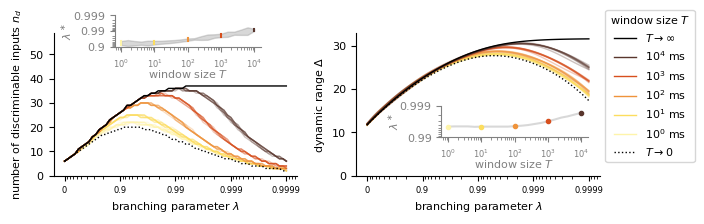

In [9]:
plt.text.usetex : True
# font size
plt.rcParams.update({'font.size': 8})
# # tick size
plt.rcParams['xtick.labelsize'] = 6

# set figure size to max width (Nature=18cm, APS=17.2cm)
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(1, 2, figsize=(18*cm, 6*cm))
#fig, ax = plt.subplots(1, 2, figsize=(10,4))
for (i,window) in enumerate(focus_windows):
    for (s, seed) in enumerate(seeds):
        ax[0].plot(1-focus_lam[i][s], focus_nds[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)
        ax[1].plot(1-focus_lam[i][s], focus_drs[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)

# discriminable intervals
ax[0].plot(1 - lams_inf, nds_inf, color="black", linewidth=1.0)
if len(nds_0)>0:
    ax[0].plot(1 - lams_0, nds_0, color="black", linestyle='dotted', linewidth=1.0)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 59)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# inset
axins=[]
axins.append(ax[0].inset_axes([0.25, 0.90, 0.6, 0.22]))
# plot bars between upper and lower bound
upper = 1-lam_max_nds_lower
lower = 1-lam_max_nds_upper
axins[0].fill_between(windows, lower, upper, color="gray", alpha=0.3)
for (i,window) in enumerate(focus_windows):
    # get index of window in windows
    index = np.where(windows == window)[0][0]
    axins[0].plot([window, window], [1-lam_max_nds_lower[index], 1-lam_max_nds_upper[index]], color=focus_colors[i])

# dynamic range
ax[1].plot(1 - lams_inf, drs_inf, color="black", linewidth=1.0)
if len(drs_0)>0:    
    ax[1].plot(1 - lams_0, drs_0, color="black", linestyle='dotted', linewidth=1.0)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 33)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()
# remove boundaries top and right
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# insets with the development of maximum values with window size
axins.append(ax[1].inset_axes([0.35, 0.27, 0.6, 0.22]))
# plot mean with error bars
axins[1].plot(windows, 1-lam_max_drs_mean, color="gray", alpha=0.3)
for (i,window) in enumerate(focus_windows):
    # get index of window in windows
    index = np.where(windows == window)[0][0]
    axins[1].errorbar(window, 1-lam_max_drs_mean[index], yerr=lam_max_drs_std[index], color=focus_colors[i], markersize=3, marker='o')

# set inset labels gray
for inset in axins:
    # remove boundaries top and right
    inset.spines['top'].set_visible(False)
    inset.spines['right'].set_visible(False)
    # x gray
    inset.spines['bottom'].set_color('gray')
    inset.xaxis.label.set_color('gray')
    inset.tick_params(axis='x', colors='gray')
    inset.tick_params(axis='x', which='minor', colors='gray')
    # y gray
    inset.spines['left'].set_color('gray')
    inset.yaxis.label.set_color('gray')
    inset.tick_params(axis='y', colors='gray')
    inset.tick_params(axis='y', which='minor', colors='gray')
    # x label
    inset.set_xlabel("window size $T$", labelpad=-1)
    inset.set_xscale("log")
    # y label
    inset.set_ylabel("$\lambda^\\ast$", labelpad=-1)
    inset.set_yscale("log")
    inset.invert_yaxis()
    if inset == axins[0]:
        inset.set_yticks([1e-1, 1e-2, 1e-3])
        inset.set_yticklabels(["0.9", "0.99", "0.999"])
    if inset == axins[1]:
        inset.set_yticks([1e-2, 1e-3])
        inset.set_yticklabels(["0.99", "0.999"])
        plt.setp(inset.get_yminorticklabels(), visible=False)


# set labels for colors 
ax[0].plot([], [], color='black', linestyle='dotted', label='$T \\to 0$', linewidth=1.0)
for i, window in enumerate(focus_windows):
    ax[0].plot([], [], color=focus_colors[i], label=focus_legends[i], linewidth=1.0)
ax[0].plot([], [], color='black', label='$T \\to \infty$', linewidth=1.0)
# reverse order of legend
handles, labels = ax[0].get_legend_handles_labels()
# set legend outside of main plots
ax[1].legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(1.00, 1.2), title="window size $T$")
plt.tight_layout()
plt.savefig("figures/fig_results.pdf", bbox_inches='tight', dpi=600)

# case nu=0.2

In [10]:
import sqlite3
con = sqlite3.connect('simulations_nu0.2.db')
cur = con.cursor()
# load dataframe from table
sub_results = pd.read_sql_query(f"SELECT * FROM results WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND sigma={params['sigma']} AND epsilon={params['epsilon']}", con)
sub_results.drop(columns=['N', 'K', 'mu', 'sigma', 'epsilon'], inplace=True)
con.close()

sub_results.seed.unique()

array([1000])

In [11]:
# check consistency for subsequent analysis: all seeds should have all windows!
for seed in sub_results.seed.unique():
    for window in sub_results.window.unique():
        if not len(sub_results[(sub_results.seed==seed) & (sub_results.window==window)])==1:
            print(f"seed {seed} window {window} not found!")

In [12]:
# load data and calculate maxima of drs and nds
windows = np.sort(sub_results["window"].unique())
focus_windows = [1e0,1e1,1e2,1e3,1e4]
focus_legends = ["$10^0$ ms", "$10^1$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]
seeds = np.sort(sub_results.seed.unique())
seeds = [1000,]
#print(seeds)

sub_focus_lam = [[] for i in range(len(focus_windows))]
sub_focus_nds = [[] for i in range(len(focus_windows))]
sub_focus_drs = [[] for i in range(len(focus_windows))]
sub_lam_max_nds = [[] for i in range(len(windows))]
sub_lam_max_drs = [[] for i in range(len(windows))]
# iterate over all windows
for (i,window) in enumerate(windows):
    # reduce dataframe to current window
    sel = sub_results[sub_results["window"] == window]
    for (s, seed) in enumerate(seeds):
        # load file
        filename = sub_results[(sub_results["window"] == window) & (sub_results["seed"] == seed)].filename.values[0]
        print(filename)
        # reduce filename to the path from ./results/
        filename = filename[filename.find("results/"):] 
        lams_data, drs_data, nds_data = np.loadtxt(f"{filename}", skiprows=1, unpack=True)
        # find lamda value of maximum from left and from right
        sub_lam_max_nds[i].append([lams_data[np.argmax(nds_data)], lams_data[len(nds_data) - np.argmax(nds_data[::-1]) - 1]])
        sub_lam_max_drs[i].append([lams_data[np.argmax(drs_data)], lams_data[len(drs_data) - np.argmax(drs_data[::-1]) - 1]])
        if not len(lams_data) > 60:
            print("problem with result {}_{}".format(window, seed))
        if window in focus_windows:
            sub_focus_lam[focus_windows.index(window)].append(lams_data)
            sub_focus_nds[focus_windows.index(window)].append(nds_data)
            sub_focus_drs[focus_windows.index(window)].append(drs_data)

# for each window calculate the mean lower and upper lambda value
sub_lam_max_nds = np.array(sub_lam_max_nds)
sub_lam_max_drs = np.array(sub_lam_max_drs)
# for nds plot range
sub_lam_max_nds_lower = np.mean(sub_lam_max_nds[:, :, 0], axis=1)
sub_lam_max_nds_upper = np.mean(sub_lam_max_nds[:, :, 1], axis=1)

# for drs calculate mean and variance (after mean over bounds, axis=2)
sub_lam_max_drs_mean = np.mean(np.mean(sub_lam_max_drs, axis=2), axis=1)
sub_lam_max_drs_std = np.std(np.mean(sub_lam_max_drs, axis=2), axis=1)

./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=1.0.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=1.5848931924611136.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=2.51188643150958.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=3.9810717055349722.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=6.309573444801933.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=10.0.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=15.848931924611133.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/results_simulation_seed=1000_window=25.118864315095795.txt
./results/nu=0.2//sigma=0.01_epsilon=0.1/N=10000_K=100_mu=0.2/re

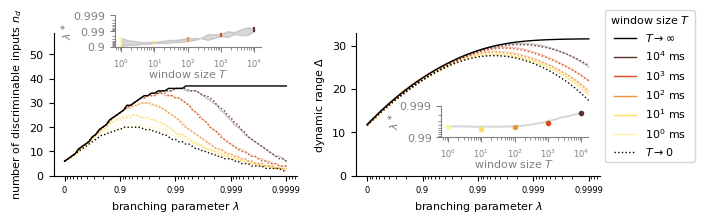

In [13]:
plt.text.usetex : True
# font size
plt.rcParams.update({'font.size': 8})
# # tick size
plt.rcParams['xtick.labelsize'] = 6

# set figure size to max width (Nature=18cm, APS=17.2cm)
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(1, 2, figsize=(18*cm, 6*cm))
#fig, ax = plt.subplots(1, 2, figsize=(10,4))
for (i,window) in enumerate(focus_windows):
    for (s, seed) in enumerate(seeds):
        ax[0].plot(1-sub_focus_lam[i][s], sub_focus_nds[i][s], color=focus_colors[i], alpha=1, linewidth=1.0, linestyle='dotted')
        ax[1].plot(1-sub_focus_lam[i][s], sub_focus_drs[i][s], color=focus_colors[i], alpha=1, linewidth=1.0, linestyle='dotted')
        ax[0].plot(1-focus_lam[i][s], focus_nds[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)
        ax[1].plot(1-focus_lam[i][s], focus_drs[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)

# discriminable intervals
ax[0].plot(1 - lams_inf, nds_inf, color="black", linewidth=1.0)
if len(nds_0)>0:
    ax[0].plot(1 - lams_0, nds_0, color="black", linestyle='dotted', linewidth=1.0)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 59)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# inset
axins=[]
axins.append(ax[0].inset_axes([0.25, 0.90, 0.6, 0.22]))
# plot bars between upper and lower bound
upper = 1-sub_lam_max_nds_lower
lower = 1-sub_lam_max_nds_upper
axins[0].fill_between(windows, lower, upper, color="gray", alpha=0.3)
for (i,window) in enumerate(focus_windows):
    # get index of window in windows
    index = np.where(windows == window)[0][0]
    axins[0].plot([window, window], [1-sub_lam_max_nds_lower[index], 1-sub_lam_max_nds_upper[index]], color=focus_colors[i])

# dynamic range
ax[1].plot(1 - lams_inf, drs_inf, color="black", linewidth=1.0)
if len(drs_0)>0:    
    ax[1].plot(1 - lams_0, drs_0, color="black", linestyle='dotted', linewidth=1.0)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 33)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()
# remove boundaries top and right
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# insets with the development of maximum values with window size
axins.append(ax[1].inset_axes([0.35, 0.27, 0.6, 0.22]))
# plot mean with error bars
axins[1].plot(windows, 1-sub_lam_max_drs_mean, color="gray", alpha=0.3)
for (i,window) in enumerate(focus_windows):
    # get index of window in windows
    index = np.where(windows == window)[0][0]
    axins[1].errorbar(window, 1-sub_lam_max_drs_mean[index], yerr=sub_lam_max_drs_std[index], color=focus_colors[i], markersize=3, marker='o')

# set inset labels gray
for inset in axins:
    # remove boundaries top and right
    inset.spines['top'].set_visible(False)
    inset.spines['right'].set_visible(False)
    # x gray
    inset.spines['bottom'].set_color('gray')
    inset.xaxis.label.set_color('gray')
    inset.tick_params(axis='x', colors='gray')
    inset.tick_params(axis='x', which='minor', colors='gray')
    # y gray
    inset.spines['left'].set_color('gray')
    inset.yaxis.label.set_color('gray')
    inset.tick_params(axis='y', colors='gray')
    inset.tick_params(axis='y', which='minor', colors='gray')
    # x label
    inset.set_xlabel("window size $T$", labelpad=-1)
    inset.set_xscale("log")
    # y label
    inset.set_ylabel("$\lambda^\\ast$", labelpad=-1)
    inset.set_yscale("log")
    inset.invert_yaxis()
    if inset == axins[0]:
        inset.set_yticks([1e-1, 1e-2, 1e-3])
        inset.set_yticklabels(["0.9", "0.99", "0.999"])
    if inset == axins[1]:
        inset.set_yticks([1e-2, 1e-3])
        inset.set_yticklabels(["0.99", "0.999"])
        plt.setp(inset.get_yminorticklabels(), visible=False)


# set labels for colors 
ax[0].plot([], [], color='black', linestyle='dotted', label='$T \\to 0$', linewidth=1.0)
for i, window in enumerate(focus_windows):
    ax[0].plot([], [], color=focus_colors[i], label=focus_legends[i], linewidth=1.0)
ax[0].plot([], [], color='black', label='$T \\to \infty$', linewidth=1.0)
# reverse order of legend
handles, labels = ax[0].get_legend_handles_labels()
# set legend outside of main plots
ax[1].legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(1.00, 1.2), title="window size $T$")
plt.tight_layout()
plt.savefig("figures/fig_results_nu0.2.pdf", bbox_inches='tight', dpi=600)